In [1]:
# Implementation of a 2-layer MLP for FashionMNIST in PyTorch

# To install pytorch on my system (MacBook and Anaconda python distribution), I used:
# conda install pytorch torchvision torchaudio -c pytorch
# search for directions for your system

# Refer to 
# https://d2l.ai/chapter_preliminaries/index.html (just chapter 2)
# https://pytorch.org/tutorials/beginner/basics/intro.html
# for PyTorch basics.

import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the FashionMNIST Datasets for test and training

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
training_data # a verbose description of the dataset
#len(training_data) # there are 60000 training data points
#training_data[0] # each entry in the training data set is a tuple of the image and the label
#training_data[0][0] # first entry in each training tuple is a 28-by-28 tensor of numbers in [0,1]
#training_data[0][1] # second entry is the class label (number)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

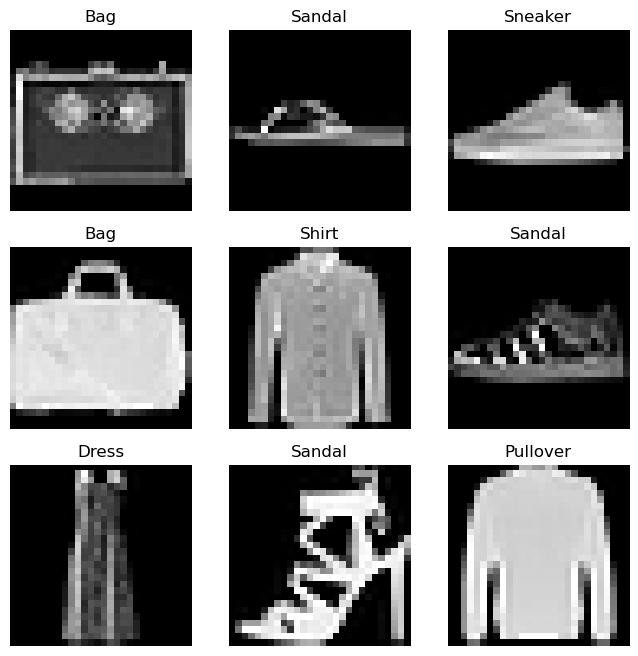

In [4]:
# Visualize the classes in FashionMNIST, straight from the PyTorch Dataset and DataLoader tutorial

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# Create a class representing our neural network by subclassing the Module class
class TwoLayerMLP(nn.Module):
   
    # in the init function we create the structure (layers) of the neural network
    def __init__(self, d, n1, k):
        super(TwoLayerMLP, self).__init__()
        self.flatten = nn.Flatten() # a layer that flattens each example in the input minibatch into a 1d tensor
        self.l1 = nn.Linear(d, n1)
        self.s1 = nn.Tanh() # try ReLU
        self.l2 = nn.Linear(n1, k)

    def forward(self, x):
        # Given a tensor x containing a minibatch of examples, so size [m, d]
        # returns a tensor containing the logits of each example
        x = self.flatten(x)
        x = self.s1(self.l1(x))
        logits = self.l2(x)
        return logits

In [6]:
# Example of applying to a single datapoint
d = 28*28
n1 = 400
k = 10

classifier = TwoLayerMLP(d, n1, k)
x = training_data[0][0]
yhat = classifier(x)
yhat.detach()

tensor([[-0.2988,  0.0761, -0.0210,  0.0156,  0.1333, -0.0328,  0.1754,  0.0070,
          0.0520,  0.3199]])

In [7]:
# Before training, determine if we have access to a GPU 
# and use it if so (faster), otherwise fall back to CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = TwoLayerMLP(d, n1, k).to(device)
print(model)

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print('The number of parameters in the model is', num_params)

Using cpu device
TwoLayerMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (s1): Tanh()
  (l2): Linear(in_features=400, out_features=10, bias=True)
)
The number of parameters in the model is 318010


In [8]:
# Set our hyperparameters for training
lr = 1e-3
batch_size = 64
epochs = 5

# DataLoaders will return randomly shuffled minibatches in each epoch
train_loader = DataLoader(training_data, batch_size=batch_size, 
                              shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# set the loss function
criterion = nn.CrossEntropyLoss() # takes logits and true class as input; computes the MEAN loss over a minibatch by default

In [9]:
# Does one epoch of training

def train_epoch(dataloader, model, criterion, optimizer):
    
    size = len(dataloader.dataset)
    
    for batchnum, (X, y) in enumerate(dataloader):
        # Compute prediction and loss on the minibatch
        yhat = model(X) # this calls forward on the minibatch (do not call forward directly)
        loss = criterion(yhat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0:
            # report the loss on current minibatch every 100 minibatches
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
# Computes loss and accuracy on the validation set

def validate(dataloader, model, criterion):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # we don't want to accumulate the gradients during validation
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# Train

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train() # turn model to train mode (for dropout, etc)
    train_epoch(train_loader, model, criterion, optimizer)
    model.eval() # turn model to evaluation mode (for dropout, etc)
    validate(test_loader, model, criterion)
    
    
print("Done!")

Epoch 1
-------------------------------
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
loss: 2.308894  [    0/60000]
loss: 0.570280  [ 6400/60000]
loss: 0.473313  [12800/60000]
loss: 0.408370  [19200/60000]
loss: 0.294347  [25600/60000]
loss: 0.288197  [32000/60000]
loss: 0.454480  [38400/60000]
loss: 0.461730  [44800/60000]
loss: 0.348983  [51200/60000]
loss: 0.223328  [57600/60000]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Lib

In [11]:
# To use the model in practice, e.g.

x, y = test_data[7]
model.eval()
yhat = model(x).detach()
yhat = yhat.argmax().item()

print(f'True class: {y}, Predicted class: {yhat}')

True class: 6, Predicted class: 6


In [12]:
# Save (pickle) the model to file
torch.save(model, 'twolayermlp.pth') 
model2 = torch.load('twolayermlp.pth')
model2.eval() # always use this before using a model at inference time

TwoLayerMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (s1): Tanh()
  (l2): Linear(in_features=400, out_features=10, bias=True)
)